In [50]:
import numpy as np
import codecs
import argparse
import matplotlib
import matplotlib.pyplot as plt
import random
import math
import subprocess
import sys
from collections import deque, Counter, defaultdict, namedtuple, OrderedDict
import scipy
from matplotlib.backends.backend_pdf import PdfPages

from tools import dependency, sentence_attentions
from tqdm import tqdm

%matplotlib inline

# LOAD ATTENTION

In [51]:
selected_model = 'dev'
if selected_model == 'dev':
    attention_file = '../BertAA/BertAA-dev/attentions.npz'
    token_file = '../BertAA/BertAA-dev/source.txt'
    conllu_file_name = '../graph-extraction/endev-conv.conllu'
    no_softmax = False
elif selected_model == 'test':
    attention_file = '../BertAA/attentions.npz'
    token_file = '../BertAA/source.txt'
    conllu_file_name = '../data/entest.conllu'
    no_softmax = True
    
elif selected_model == 'fr-uncased':
    attention_file = '../BertAA/BertAA-ml-fr/attentions.npz'
    token_file = '../BertAA/BertAA-ml-fr/source.txt'
    conllu_file_name = '../graph-extraction/frdev-conv.conllu'
    no_softmax = False
    
elif selected_model == 'de-uncased':
    attention_file = '../BertAA/BertAA-ml-de/attentions.npz'
    token_file = '../BertAA/BertAA-ml-de/source.txt'
    conllu_file_name = '../graph-extraction/dedev-conv.conllu'
    no_softmax = False
    
elif selected_model == 'en-uncased':
    attention_file = '../BertAA/BertAA-ml-en/attentions.npz'
    token_file = '../BertAA/BertAA-ml-en/source.txt'
    conllu_file_name = '../graph-extraction/endev-conv.conllu'
    no_softmax = False
    

maxlen = 1000



#this is necessary in this case
eos =True

dependency_rels = dependency.read_conllu(conllu_file_name,True)

with open(token_file) as tokens_file:
    tokens_loaded = [l.split() for l in tokens_file]
    
attentions_loaded = np.load(attention_file)
sentences_count = 1000
layers_count = attentions_loaded['arr_0'].shape[0]
heads_count = attentions_loaded['arr_0'].shape[1]

token_ids_grouped, words_lists = dependency.group_wordpieces(tokens_loaded, conllu_file_name)

words_lists = {idx : wl for idx, wl in enumerate(words_lists)}

sentences = [8, 17, 92, 117]
attention_gen = sentence_attentions.generate_matrices(attentions_loaded, token_ids_grouped, eos, no_softmax, maxlen,sentences)
#attention_gen = enumerate(attention_gen)

viss = {sentence_idx: att_mts for att_mts, sentence_idx in tqdm(attention_gen)}

4it [00:01,  3.06it/s]


## SELECTED HEADS

In [5]:

RelData= namedtuple('RelData','layers heads transpose d2p')
RelData2 = namedtuple('RelData', 'layers heads layersT headsT weight weightT')
relation_rules  = OrderedDict(sorted({'adj-clause-p2d': RelData([4, 7, 6, 0], [5, 6, 5, 8],False, False),
    'adj-modifier-d2p': RelData([3, 7, 6, 5], [9, 10, 5, 7],False, True),
    'adv-clause-d2p': RelData([4, 4, 8, 3], [9, 3, 8, 1],False, True),
    'adv-modifier-d2p': RelData([7, 3, 6, 8], [6, 10, 5, 5],False, True),
    'all-d2p': RelData([3, 7, 3, 4], [9, 10, 10, 5],False, True),
    'apposition-p2d': RelData([0, 9], [8, 0],False, False),
    'auxiliary-d2p': RelData([3, 8, 7, 4], [9, 5, 10, 5],False, True),
    'clausal subject-p2d': RelData([8, 0, 0, 0], [10, 8, 5, 1],False, False),
    'clausal-d2p': RelData([7, 5, 4, 8], [0, 4, 6, 8],False, True),
    'compound-d2p': RelData([3, 5, 6, 0], [9, 11, 5, 8],False, True),
    'conjunct-d2p': RelData([4, 6, 1, 5], [3, 0, 10, 4],False, True),
    'determiner-d2p': RelData([7, 3, 4, 8], [10, 9, 5, 10],False, True),
    'noun-modifier-p2d': RelData([4, 0, 0, 3], [5, 8, 1, 3],False, False),
    'num-modifier-d2p': RelData([7, 6, 3, 1], [10, 5, 10, 5],False, True),
    'object-d2p': RelData([7, 6, 4, 5], [9, 9, 6, 3],False, True),
    'other-d2p': RelData([7, 4, 8, 0], [10, 5, 5, 8],False, True),
    'punctuation-p2d': RelData([11, 7, 2, 11], [6, 7, 2, 2],False, False),
    'subject-p2d': RelData([7, 4], [11, 10],False, False),
    'adj-clause-d2p': RelData([6, 4, 0, 8], [4, 6, 3, 10],False, True),
    'adj-modifier-p2d': RelData([3, 5, 0, 4], [5, 1, 2, 7],False, False),
    'adv-clause-p2d': RelData([4, 5, 5, 0], [3, 4, 8, 8],False, False),
    'adv-modifier-p2d': RelData([7, 4, 0, 6], [3, 7, 11, 2],False, False),
    'all-p2d': RelData([1, 0, 7, 0], [4, 2, 4, 11],False, False),
    'apposition-d2p': RelData([4, 0, 4, 3], [3, 9, 9, 8],False, True),
    'auxiliary-p2d': RelData([7, 6, 7, 6], [4, 3, 3, 9],False, False),
    'clausal subject-d2p': RelData([9, 1, 2, 1], [2, 11, 4, 8],False, True),
    'clausal-p2d': RelData([5, 6, 7, 5], [7, 7, 6, 8],False, False),
    'compound-p2d': RelData([3, 6, 0, 7], [5, 5, 2, 4],False, False),
    'conjunct-p2d': RelData([5, 4, 0, 4], [5, 3, 8, 4],False, False),
    'determiner-p2d': RelData([5, 1, 3, 8], [6, 4, 2, 6],False, False),
    'noun-modifier-d2p': RelData([7, 0, 5, 0], [9, 8, 3, 7],False, True),
    'num-modifier-p2d': RelData([7, 9, 1, 0], [11, 4, 10, 8],False, False),
    'object-p2d': RelData([7, 4, 0, 3], [10, 5, 8, 9],False, False),
    'other-p2d': RelData([6, 8], [9, 6],False, False),
    'punctuation-d2p': RelData([4, 8, 3, 7], [5, 5, 9, 5],False, True),
    'subject-d2p': RelData([5, 1, 7, 7], [9, 6, 1, 8],False, True)}.items()))

## VISUAL PART

In [39]:
plt.style.use('PapeFig.mplstyle')

In [7]:
def plot_averaged_heads_vertical(viss,words_lists,sent_idx, ls, hs, dep_rels,rel_types, title):
    rel2lab = {'adj-modifier-d2p' : 'AMOD D2P', 'object-d2p': 'OBJ D2P', 'subject-p2d': "NSUBJ P2D", 'auxiliary-d2p': 'AUX D2P'}
    #rel2mark = {'adj-modifier-d2p': 'A', 'determiner-d2p': 'D', 'auxiliary-d2p': 'X', 'object-d2p': 'O'}
    cmaps = ['Purples', 'Blues', 'Greens', 'Oranges']
    to_romans = ['I', 'II', 'III', 'IV']
    num_cols = len(ls)
    num_rows = len(ls[0]) +1
    fig, axes = plt.subplots(num_rows,num_cols,figsize=(num_rows*4,num_cols*6),tight_layout=True)

    matrices = np.array(viss[sent_idx])
    
    for  jdx, ax_row in enumerate(axes):
        for idx, ax in enumerate(ax_row):
            #plt.subplot(num_rows,num_cols, idx *+ jdx )
            #ax=plt.gca()

            
            if jdx == 0:
                matrix = np.average(matrices[ls[idx],hs[idx],:,:], axis=0)
            elif jdx > len(ls[idx]):
#                 im = ax.imshow(np.zeros((len(words_lists[sent_idx]),len(words_lists[sent_idx]))),
#                                cmap=cmaps[idx% len(cmaps)], vmin=0, vmax=1)
                ax.axis('off')
                continue
            else:
                matrix = matrices[ls[idx][jdx-1],hs[idx][jdx-1],:,:]
            
            
            np.fill_diagonal(matrix, 0)
            im = ax.imshow(matrix,cmap=cmaps[idx% len(cmaps)])
            for i, j in dep_rels[sent_idx][rel_types[idx]]:
                mark = 'X' #rel2mark[rel_types[idx]]
                ax.text(j, i, mark, ha="center", va="center", color="red")
            if jdx == 0:
                ax.set_title(rel2lab[rel_types[idx]])
                
                head_title = 'AVERAGED'
            else:
                head_title = f'HEAD {to_romans[jdx-1]}'
                
            #ax.set_xticks(np.arange(len(words_lists[sent_idx])))
            if jdx == num_rows -1:    
                ax.set_xticks(np.arange(len(words_lists[sent_idx])))
                ax.set_xticklabels(words_lists[sent_idx], rotation=90)
            else:
                ax.set_xticklabels([])

            if idx == 0:
                
                ax.set_yticks(np.arange(len(words_lists[sent_idx])))
                ax.set_yticklabels(words_lists[sent_idx], rotation=0)
                ax.set_ylabel(head_title)
                ax.set_ylim(top=-0.5, bottom=len(words_lists[sent_idx])-0.5)
            else:
                ax.set_yticklabels([])

    fig.tight_layout(pad=0.01, w_pad=0.01, h_pad=0.01)
    fig.subplots_adjust(wspace=0.01, hspace=0.01)
    fig.savefig(title,dpi=300, format='pdf', bbox_inches='tight', tight_layout_layout=True)
    fig.show()
    

In [ ]:
[7, 4], [11, 10]

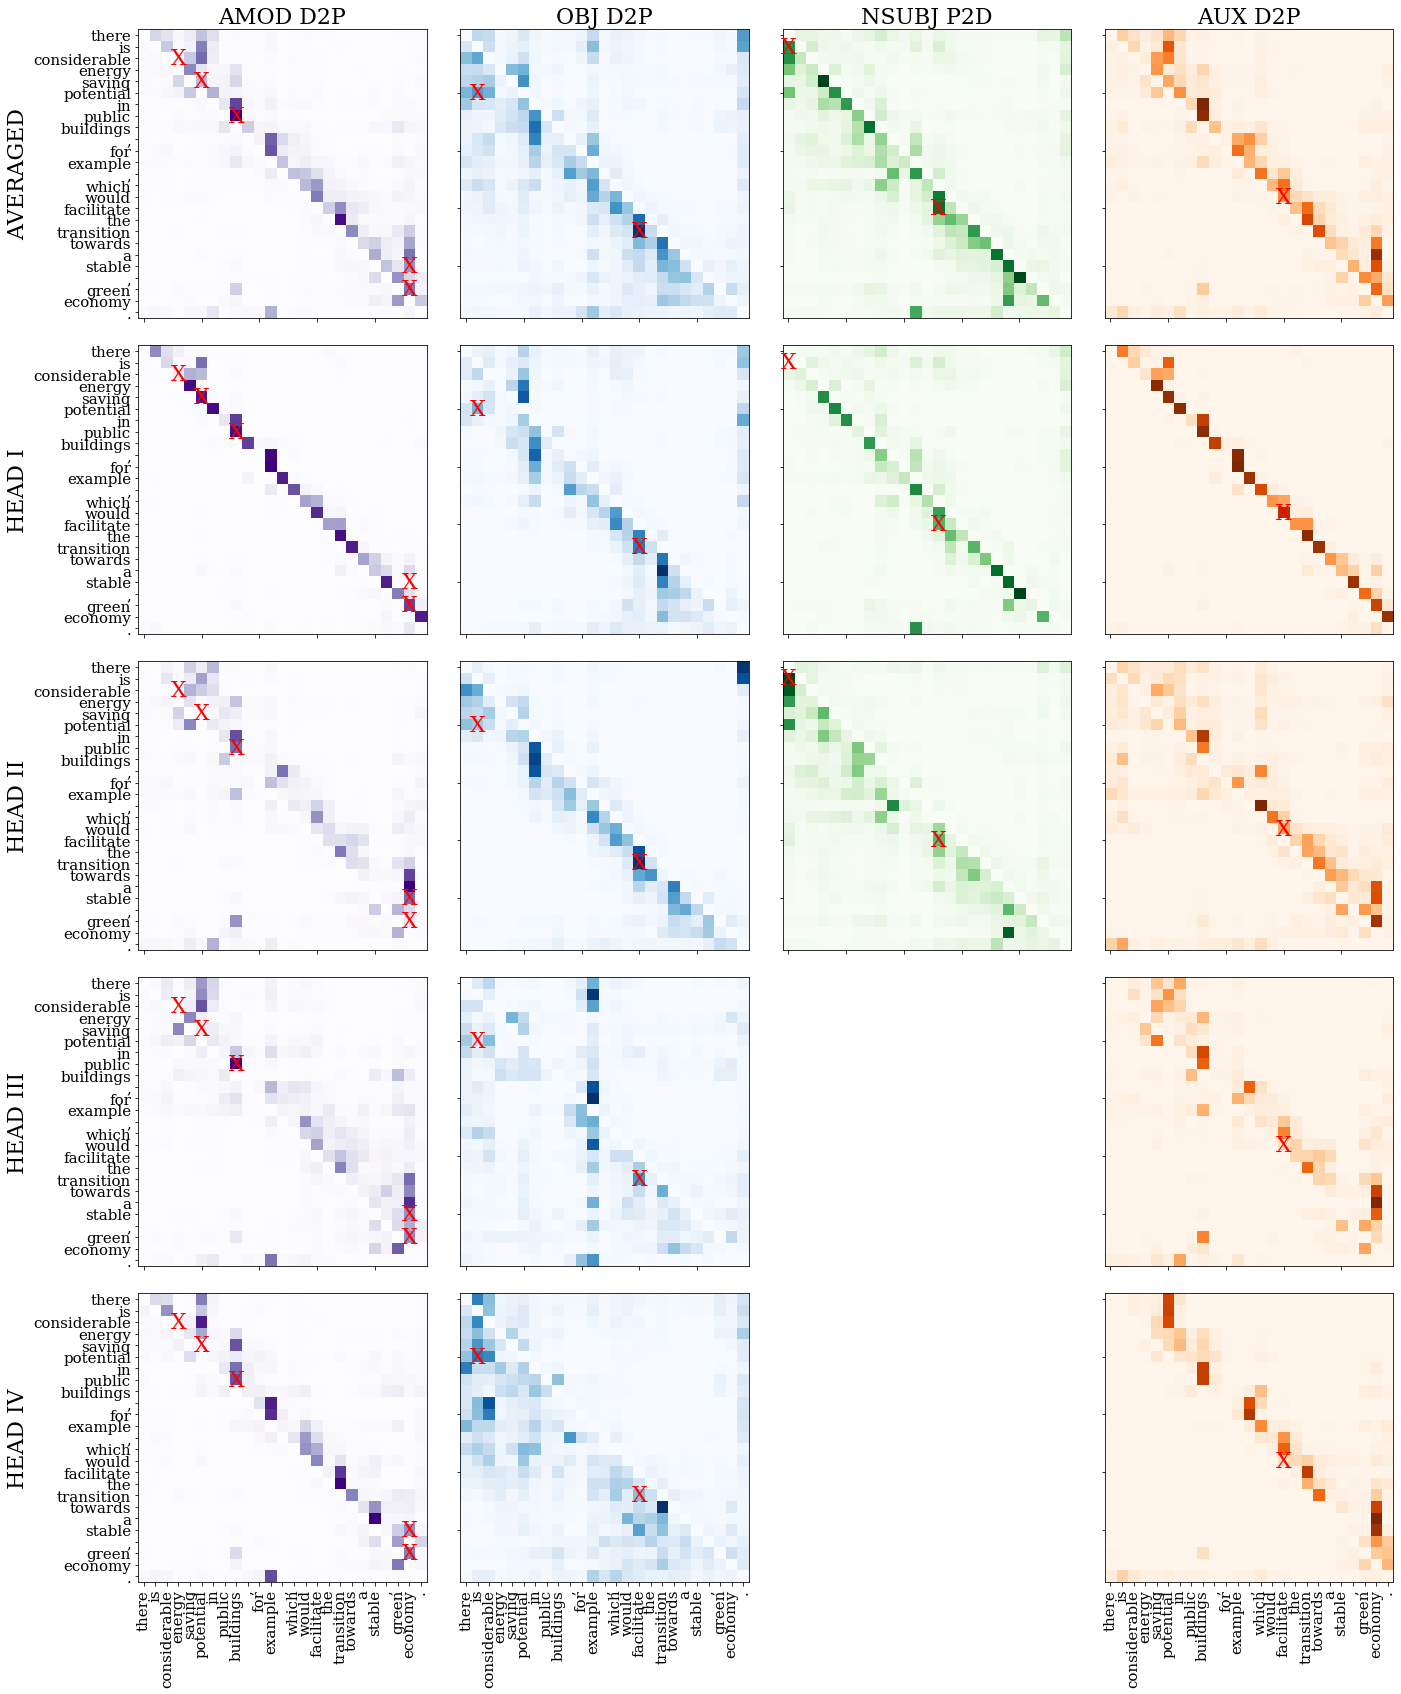

In [8]:
ls = [ [3, 7, 6, 5],[7, 6, 4, 5],[7, 4],[3, 8, 7, 4]] 
hs = [[9, 10, 5, 7],[9, 9, 6, 3],[11, 10],[9, 5, 10, 5]]
rel_types = ['adj-modifier-d2p', 'object-d2p', 'subject-p2d', 'auxiliary-d2p']
sent_idx = 17


plot_averaged_heads_vertical(viss, words_lists, sent_idx, ls, hs, dependency_rels, rel_types, 'HeadAnalysisVerticalLarge.pdf')

In [9]:
def plot_averaged_heads_horizontal(viss,words_lists,sent_idx, ls, hs, dep_rels,rel_types, title):
    cmaps = ['Purples', 'Blues', 'Greens']
    rel2mark = {'adj-modifier-d2p': 'A', 'determiner-d2p': 'D', 'auxiliary-d2p': 'X', 'object-d2p': 'O'}
    
    rel2lab = {'adj-modifier-d2p' : 'AMOD D2P', 'object-d2p': 'OBJ D2P'}
    to_romans = ['I', 'II', 'III', 'IV']
    num_cols = len(ls[0]) +1
    num_rows =  len(ls)
    
    fig, axes = plt.subplots(num_rows,num_cols,figsize=(num_rows*6,num_cols*4),tight_layout=True)
    matrices = np.array(viss[sent_idx])
    
    for  jdx, ax_row in enumerate(axes.transpose()):
        for idx, ax in enumerate(ax_row):

            if jdx == 0:
                matrix = np.average(matrices[ls[idx],hs[idx],:,:], axis=0)
            else:
                matrix = matrices[ls[idx][jdx-1],hs[idx][jdx-1],:,:]
            
            
            np.fill_diagonal(matrix, 0)
            im = ax.imshow(matrix,cmap=cmaps[idx% len(cmaps)])
            for i, j in dep_rels[sent_idx][rel_types[idx]]:
                mark = 'X'
                ax.text(j, i, mark, ha="center", va="center", color="red")
            if jdx == 0:
                head_title = 'AVERAGED'
            else:
                head_title = f'HEAD {to_romans[jdx-1]}'
                
                
            if jdx == 0:    
                ax.set_yticks(np.arange(len(words_lists[sent_idx])))
                ax.set_yticklabels(words_lists[sent_idx])
                ax.set_ylabel(rel2lab[rel_types[idx]])
                ax.set_ylim(top=-0.5, bottom=len(words_lists[sent_idx])-0.5)
            else:
                ax.yaxis.set_ticklabels([])

            if idx == num_rows -1:  
                ax.set_xticks(np.arange(len(words_lists[sent_idx])))
                ax.set_xticklabels(words_lists[sent_idx], rotation=90)
            elif idx == 0:
                ax.set_title(head_title)
                ax.set_xticklabels([])
            else:
                ax.set_xticklabels([])
                
    fig.tight_layout(pad=0.01, w_pad=0.01, h_pad=0.01, rect=(0,0,1,1))
    fig.subplots_adjust(wspace=0.01, hspace=0.01)
    fig.savefig(title,dpi=300,format='pdf', bbox_inches='tight', pad_inches = 0)
    fig.show()


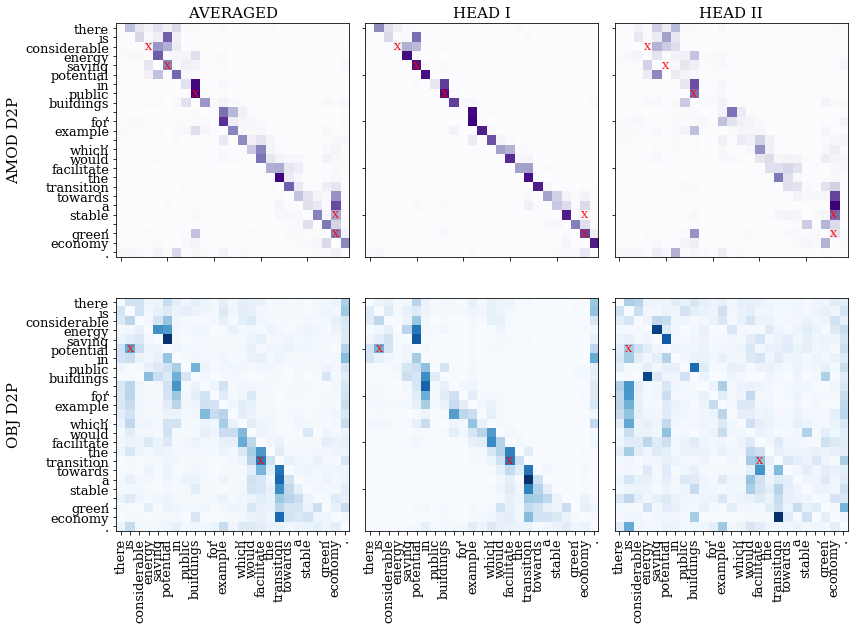

In [121]:
ls = [ [3, 7],[7, 3]] 
hs = [[9,10],[9, 8]]
rel_types = ['adj-modifier-d2p', 'object-d2p']
sent_idx = 17

plot_averaged_heads_horizontal(viss, words_lists, sent_idx, ls, hs, dependency_rels, rel_types, 'HeadAnalysisHorizontal.pdf')

In [10]:
def plot_relation_ensemble(viss,words_lists, idx,relation_rules, dep_rels,rel_type, title):

    fig, ax = plt.subplots(1,1,figsize=(6,6))

    rules = relation_rules[rel_type]
    matrix = np.array(viss[idx])

    matrix = np.average(matrix[rules.layers,rules.heads,:,:], axis=0)
    np.fill_diagonal(matrix, 0)

    im = ax.imshow(matrix,cmap='Greens')

#     if dep_rels and rel_type:
#         for i, j in dep_rels[idx][rel_type]:
#             ax.text(j, i, "X", ha="center", va="center", color="red")
    #ax.set_title('nsubj p2d')
    
    ax.set_xticks(np.arange(len(words_lists[idx])))
    ax.set_yticks(np.arange(len(words_lists[idx])))
    ax.set_xticklabels(words_lists[idx], rotation=90)
    ax.set_yticklabels(words_lists[idx])
    ax.set_ylim(top=-0.5, bottom=len(words_lists[idx])-0.5)
    plt.savefig(title,dpi=300, format='pdf')
    plt.show()

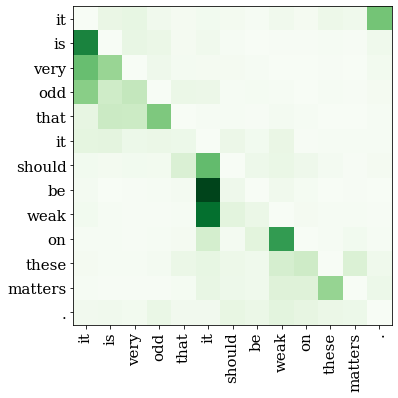

In [11]:
plot_relation_ensemble(viss, words_lists, 92, relation_rules, dependency_rels, 'subject-p2d', 'SubjectExpletiveCop.pdf')

In [43]:
def plot_multipurpose(viss,words_lists, idx,layers,heads, dep_rels,rel_types, title):

    rel2mark = {'adj-modifier-d2p': 'A', 'determiner-d2p': 'D', 'auxiliary-d2p': 'X', 'object-d2p': 'O'}
    fig, ax = plt.subplots(1,1,figsize=(6,6))

    matrix = np.array(viss[idx])

    matrix = np.average(matrix[layers,heads,:,:], axis=0)

    np.fill_diagonal(matrix, 0)
    im = ax.imshow(matrix,cmap='Purples')

    for rel_type in rel_types:
        mark = rel2mark[rel_type]
        for i, j in dep_rels[idx][rel_type]:
            ax.text(j, i, mark, ha="center", va="center", color="red")
    ax.set_xticks(np.arange(len(words_lists[idx])))
    ax.set_yticks(np.arange(len(words_lists[idx])))
    ax.set_xticklabels(words_lists[idx], rotation=90)
    ax.set_yticklabels(words_lists[idx])
    plt.savefig(title,dpi=300, format='pdf')
    ax.set_ylim(top=-0.5, bottom=len(words_lists[idx])-0.5)
    plt.show()

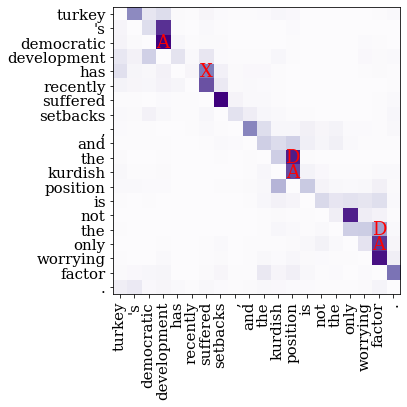

In [24]:
plot_multipurpose(viss,words_lists, 117, [3,7], [9,10],dependency_rels, ['adj-modifier-d2p', 'determiner-d2p', 'auxiliary-d2p'], 'MultipurposeHeads1.pdf')

In [56]:
' '.join(words_lists[117])

"turkey 's democratic development has recently suffered setbacks , and the kurdish position is not the only worrying factor ."

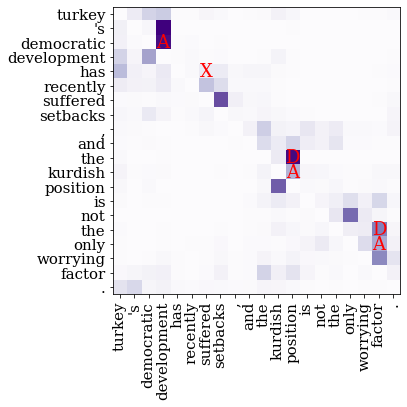

In [25]:
plot_multipurpose(viss,words_lists, 117, [7], [10],dependency_rels, ['adj-modifier-d2p', 'determiner-d2p', 'auxiliary-d2p'], 'MultipurposeHeads2.pdf')

## MULTILINGUAL VISU

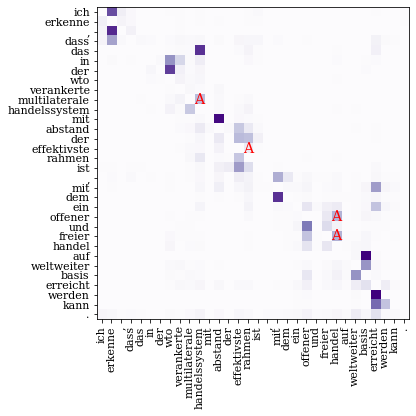

In [48]:
plot_multipurpose(viss,words_lists, 8, [5], [10],dependency_rels, ['adj-modifier-d2p'], 'MultipurposeDE.pdf')

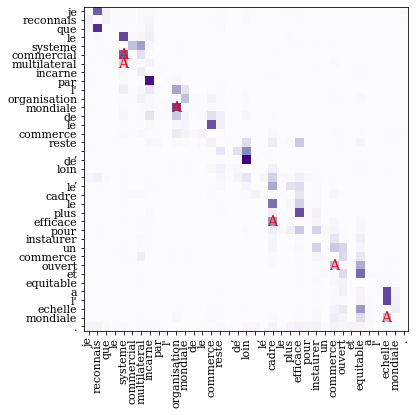

In [44]:
plot_multipurpose(viss,words_lists, 8, [5], [10],dependency_rels, ['adj-modifier-d2p'], 'MultipurposeFR.pdf')

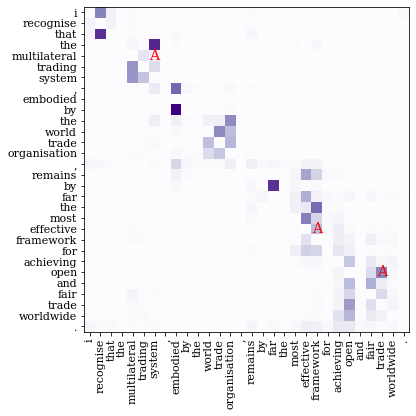

In [46]:
plot_multipurpose(viss,words_lists, 8, [5], [10],dependency_rels, ['adj-modifier-d2p'], 'MultipurposeEN.pdf')